# Параметры и гиперпараметры модели

Рассмотрим алгоритм k-NN. У нас есть **два параметра** модели, которые мы **можем настраивать**:
* метрика расстояния,
* количество ближайших соседей $k$.

Настраиваемые параметры, с помощью которых мы можем управлять процессом обучения, называются **гиперпараметрами**.

Загрузим датасет и обучим на нем k-NN используя параметры `n_neighbors=6` и `metric="chebyshev"`, посчитаем метрику `accuracy`:

In [ ]:
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

x, y = load_wine(return_X_y=True, as_frame=True)

knn = KNeighborsClassifier(n_neighbors=6, metric="chebyshev")
knn.fit(x, y)
accuracy = accuracy_score(y_pred=knn.predict(x), y_true=y)  # accuracy

print("Accuracy:", f"{accuracy*100 :0.2f}%")

Accuracy: 77.53%


Возможно, мы выбрали не самые лучшие параметры. Посчитаем `accuracy` для разных параметров:

In [ ]:
import pandas as pd

results = []

for distance_type in ["euclidean", "manhattan", "chebyshev"]:
    for k in [1, 3, 5, 7]:
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance_type)
        knn.fit(x, y)
        y_pred = knn.predict(x)
        accuracy = str(round(accuracy_score(y, y_pred) * 100)) + "%"

        results.append(
            {
                "n_neighbors": "k=" + str(k),
                "distance_type": distance_type,
                "accuracy": accuracy,
            }
        )


results_df = pd.DataFrame(results)
results_df.pivot(index="distance_type", columns="n_neighbors", values="accuracy")

n_neighbors,k=1,k=3,k=5,k=7
distance_type,,,,
chebyshev,100%,84%,78%,76%
euclidean,100%,87%,79%,75%
manhattan,100%,90%,86%,85%


Как видим, при разных параметрах качество изменяется. **Как тогда подбирать парамеры?**


# Разделение train-validation-test

Самым простым способом научиться чему-либо является "запомнить всё".

Вспомним таблицу умножения. Если мы хотим проверить умение умножать, то проверки примерами из таблицы умножения будет недостаточно, ведь она может быть полностью запомнена. Нужно давать новые примеры, которых не было в таблице умножения (обучающей выборке).

Если модель "запомнит всё", то она будет идеально работать на данных, которые мы ей показали, но может вообще не работать на любых других данных.

С практической точки зрения важно, как модель будет вести себя именно на незнакомых ей данных, то есть насколько хорошо она научилась обобщать закономерности, которые в данных присутствовали (если они вообще существуют).

Для оценки этой способности набор данных разделяют на три части:

* **Обучающая выборка** (Training set) — выборка данных, которая используется для обучения алгоритма.
* **Валидационная выборка** (Validation set) — выборка данных, которая используется для подбора параметров, выбора признаков и принятия других решений, касающихся обучения алгоритма.
* **Тестовая выборка** (Test set) — выборка, которая используется для оценки качества работы алгоритма, при этом никак не используется для обучения алгоритма или подбора используемых при этом обучении параметров.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2//L01/out/split_dataset_for_train_val_test.png" width="700"></center>

В `sklearn.model_selection` есть функция для разделения массива данных на тренировочную и тестовую часть.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split data to train/val/test
x_train, x_tmp, y_train, y_tmp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)

print("Train:", np.array(x_train).shape, np.array(y_train).shape)
print("Val:", np.array(x_val).shape, np.array(y_val).shape)
print("Test:", np.array(x_test).shape, np.array(y_test).shape)
print("Total:", np.array(x).shape, np.array(y).shape)

Train: (142, 13) (142,)
Val: (18, 13) (18,)
Test: (18, 13) (18,)
Total: (178, 13) (178,)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric="chebyshev")
knn.fit(x_train, y_train)

accuracy_train = accuracy_score(y_pred=knn.predict(x_train), y_true=y_train)
accuracy_val = accuracy_score(y_pred=knn.predict(x_val), y_true=y_val)
accuracy_test = accuracy_score(y_pred=knn.predict(x_test), y_true=y_test)

print("Accuracy train:", f"{accuracy_train*100:.02f}%")
print("Accuracy val :", f"{accuracy_val*100:.02f}%")
print("Accuracy test :", f"{accuracy_test*100:.02f}%")

Accuracy train: 100.00%
Accuracy val : 66.67%
Accuracy test : 77.78%


Вполне ожидаемо, оценка по одному соседу оказалась ошибочной. Такие случаи мы называем *переобучением*. Если теперь мы попробуем взять какой-то новый объект и классифицировать его, у нас, скорее всего, ничего не получится. В таких случаях мы говорим, что наша модель не умеет обобщать (*generalization*).

Отметим, что качество на тесте получилось заметно выше, чем на валидации. Так произошло потому, что выборки оказались нерепрезентативными, ведь мы делили данные "вслепую", случайным образом. Для того, чтобы выборки были репрезентативными, применяется стратификация.

## Стратификация

Метки классов в датасете могут быть распределены неравномерно. Для того, чтобы сохранить соотношение классов при разделении на train и val, необходимо указать параметр `stratify` при разбиении.

Еще одним параметром, используемым при разбиении, является `shuffle` (значение по умолчанию `True`). При `shuffle = True` датасет перед разбиением перемешивается.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2//L01/out/stratified_sampling.png" width="700"></center>

<center><em>Source: <a href="https://www.reneshbedre.com/blog/stratified-sampling.html">What is Stratified sampling and why should you use it</a></em></center>

Для того, чтобы убедиться в необходимости стратификации, посмотрим на разбиение датасета [Iris 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Здесь нам важно, что датасет сбалансирован, а метки отсортированы в порядке возрастания.

Будем делить датасет пополам.

In [ ]:
def count_labels(labels):
    label_count = {}
    for item in labels:
        if item not in label_count:
            label_count[item] = 0
        label_count[item] += 1
    return label_count


def print_split_stat(x_train, x_val, y_train, y_val):
    print("Train statistics: ", count_labels(y_train))
    print("Val statistics:  ", count_labels(y_val))

Посмотрим, как выглядит исходный датасет. Отметим, что **объекты отсортированы**. Ситуация вовсе не исключительная.

In [ ]:
from sklearn.datasets import load_iris

data, labels = load_iris(return_X_y=True)
print("DataSet labels:\n", labels)
print("DataSet statistics: ", count_labels(labels))

DataSet labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
DataSet statistics:  {0: 50, 1: 50, 2: 50}


Если мы **выключим перемешивание** (`shuffle=False`), то в обучение **не попадёт ни один объект класса 2**.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    data, labels, train_size=0.5, shuffle=False, random_state=42
)

print_split_stat(x_train, x_val, y_train, y_val)

Train statistics:  {0: 50, 1: 25}
Val statistics:   {1: 25, 2: 50}


По умолчанию `shuffle=True`, однако этого **не достаточно**. **Доли** объектов **не равны** в подвыборках.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    data, labels, train_size=0.5, random_state=42
)

print_split_stat(x_train, x_val, y_train, y_val)

Train statistics:  {1: 27, 2: 27, 0: 21}
Val statistics:   {1: 23, 0: 29, 2: 23}


**Только при использовании стратификации мы добиваемся желаемого результата.**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    data, labels, train_size=0.5, random_state=42, stratify=labels
)

print_split_stat(x_train, x_val, y_train, y_val)

Train statistics:  {0: 25, 1: 25, 2: 25}
Val statistics:   {0: 25, 2: 25, 1: 25}


**В случае временных рядов**, текстов и прочих данных, имеющих связь во времени, **данные нельзя перемешивать**. В таких задачах train должен предшествовать val и test по времени. Более подробно об этом будет рассказано в лекции про рекуррентные нейронные сети.


# Кросс-валидация

##Алгоритм кросс-валидации



Результат работы модели будет зависеть от разбиения. Поэкспериментируем с k-NN и датасетом [Iris 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) и посмотрим, как результат работы модели зависит от `random_state` для `train_test_split`.

In [ ]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


dataset = sklearn.datasets.load_iris()  # load data
x = dataset.data  # features
y = dataset.target  # labels(classes)

np.random.seed(42)


def split_and_train(x, y, random_state):
    x_train, x_val, y_train, y_val = train_test_split(
        x, y, train_size=0.8, stratify=y, random_state=random_state
    )

    max_neighbors = 30
    num_neighbors = np.arange(1, max_neighbors + 1)  # array of the number of neighbors

    train_accuracy = np.zeros(max_neighbors)
    val_accuracy = np.zeros(max_neighbors)

    for k in num_neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)

        train_accuracy[k - 1] = accuracy_score(
            y_pred=knn.predict(x_train), y_true=y_train
        )
        val_accuracy[k - 1] = accuracy_score(y_pred=knn.predict(x_val), y_true=y_val)

    # Accuracy plot on train and test data
    plt.figure(figsize=(10, 4))
    plt.title(f"k-NN on train vs val, seed = {random_state}", size=20)
    plt.plot(num_neighbors, train_accuracy, label="train")
    plt.plot(num_neighbors, val_accuracy, label="val")
    plt.legend()
    plt.xticks(num_neighbors, size=12)
    plt.xlabel("Neighbors", size=14)
    plt.ylabel("Accuracy", size=14)
    plt.show()

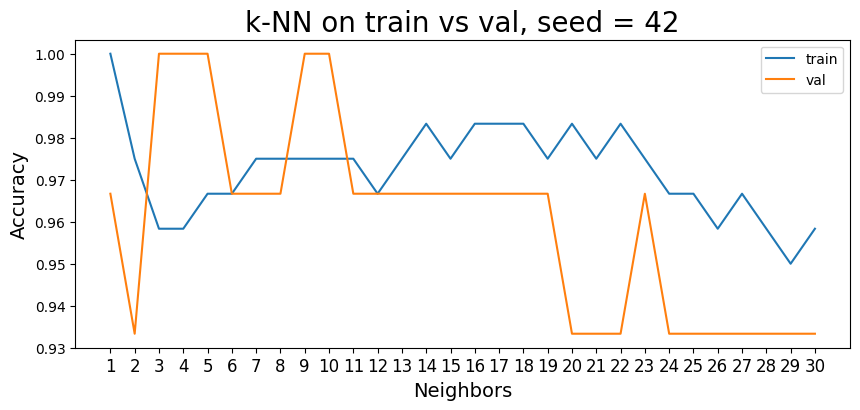

In [ ]:
split_and_train(x, y, random_state=42)

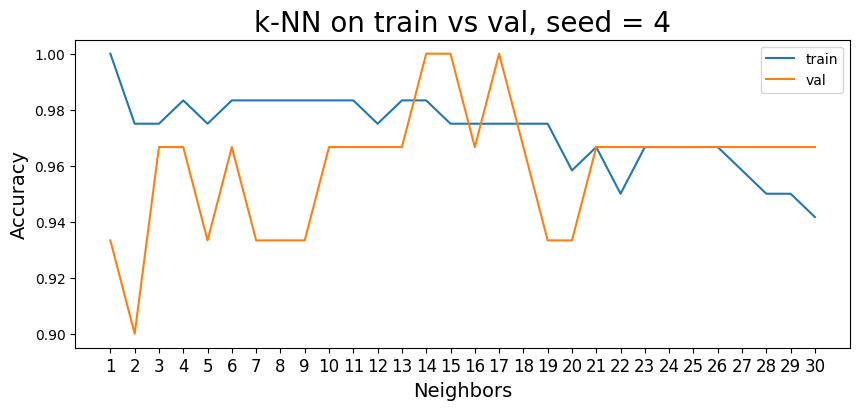

In [ ]:
split_and_train(x, y, random_state=4)

Результат зависит от того, как нам повезло или не повезло с разбиением данных на обучение и тест. Для одного разбиения хорошо выбрать $k=3$, а для другого — $k=13$. Кроме того, фактически мы сами выступаем в роли модели, которая учит гиперпараметры (а не параметры) под видимую ей выборку.




Получается, что если подбирать гиперпараметры модели на *train set*, то:
1. Можно переобучитьcя, просто на более "высоком" уровне. Особенно если гиперпараметров у модели много и все они разнообразны.
2. Нельзя быть уверенным, что выбор параметров не зависит от разбиения на обучение и валидацию.

Для решения этой проблемы можно произвести **несколько разбиений** датасета на **обучающий и валидационный** по какой-то схеме, чтобы получить уверенность оценок качества для моделей с разными гиперпараметрами.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2//L01/out/cross_validation_on_train_data.png" width="600"></center>

Такой подход называется [K-Fold кросс-валидацией 🛠️[doc]](https://scikit-learn.org/stable/modules/cross_validation.html).

Берется тренировочная часть датасета и разбивается на части — блоки. Дальше мы будем использовать для проверки первую часть (Fold 1), а на остальных частях будем обучать модель. И так последовательно для всех частей. В результате у нас будет информация о точности для разных фрагментов данных, и уже на основании этого мы сможем понять, насколько значение параметра, который мы проверяем, зависит или не зависит от данных. То есть, если у нас от разбиения точность при одном и том же $k$ меняться не будет, значит, мы подобрали правильный $k$. Если она будет сильно меняться в зависимости от того, на каком куске данных мы проводим тестирование, значит, надо попробовать другой $k$, и если ни при каком не получилось, то проблема заключается в данных.

Посмотрим, как работает K-Fold. Обратите внимание, что по умолчанию `shuffle = False`. Для упорядоченных данных это проблема.

In [ ]:
from sklearn.model_selection import KFold

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

print("index without shuffle")
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)

print("index with shuffle")
kf = KFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)

index without shuffle
TRAIN: [3 4 5 6 7 8] TEST: [0 1 2]
TRAIN: [0 1 2 6 7 8] TEST: [3 4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]
index with shuffle
TRAIN: [0 2 3 4 6 8] TEST: [1 5 7]
TRAIN: [1 3 4 5 6 7] TEST: [0 2 8]
TRAIN: [0 1 2 5 7 8] TEST: [3 4 6]


Для получения стратифицированного разбиения (когда соотношение классов в частях разбиения сохраняется) нужно использовать `StratifiedKFold` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold).

**Временные ряды**

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L01/timeseries.png" width="850"></center>
<center><em>Типичный пример временного ряда</em></center>

<center><em>Source: <a href="https://habr.com/ru/company/ods/blog/327242/">Анализ временных рядов с помощью Python</a></em></center>

Отдельно нужно упомянуть о **временных рядах**. Особенностью таких данных является связность, наличие "настоящего", "прошедшего" и "будущего".

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2//L01/out/ts_split.png" width="700"/></center>
<center><em>Разбиение данных временных рядов на подвыборки</em></center>

##Оценка результата кросс-валидации

 Посмотрим на результат кросс-валидации для k-NN.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

np.random.seed(42)

dataset = sklearn.datasets.load_iris()  # load data
x = dataset.data  # features
y = dataset.target  # labels(classes)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.8, stratify=y, random_state=42
)

cv = StratifiedKFold(n_splits=5)

knn = KNeighborsClassifier(n_neighbors=3)
accuracy3 = cross_val_score(knn, x_train, y_train, cv=cv, scoring="accuracy")

knn = KNeighborsClassifier(n_neighbors=5)
accuracy5 = cross_val_score(knn, x_train, y_train, cv=cv, scoring="accuracy")

In [ ]:
knn_cv = np.vstack(
    (
        np.hstack((accuracy3, accuracy3.mean(), accuracy3.std())),
        np.hstack((accuracy5, accuracy5.mean(), accuracy5.std())),
    )
)

In [ ]:
import pandas as pd

table = pd.DataFrame(
    knn_cv, columns=["Fold1", "Fold2", "Fold3", "Fold4", "Fold5", "Mean", "Std"]
)
table.insert(loc=0, column="k", value=[3, 5])
table = table.set_axis(["Accuracy"] * 2)

In [ ]:
table

,k,Fold1,Fold2,Fold3,Fold4,Fold5,Mean,Std
Accuracy,3,0.916667,0.958333,0.958333,0.958333,1.0,0.958333,0.026352
Accuracy,5,0.916667,1.000000,0.958333,1.000000,1.0,0.975000,0.033333


В идеальном случае выбираются гиперпараметры, для которых математическое ожидание метрик качества выше, а дисперсия — меньше.

##Типичные ошибки при кросс-валидации

**Можно ли делать только кросс-валидацию (без теста)?**

Нет, нельзя. Кросс-валидация не до конца спасает от подгона параметров модели под выборку, на которой она проводится. Оценка конечного качества модели должно производиться на отложенной тестовой выборке. Если у вас очень мало данных, можно рассмотреть [вложенную кросс-валидацию 🛠️[doc]](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html). Речь об этом пойдет в следующих лекциях. Но даже в этом случае придется анализировать поведение модели, чтобы показать, что она учит что-то разумное. Кстати, вложенную кросс-валидацию можно использовать, чтобы просто получить более устойчивую оценку поведения модели на тесте.